# H2O AutoML Binary Classification Demo

This is based upon the H2O AutoML demo at https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_binary_classification_product_backorders.ipynb, modified to show how it can be used within Dotscience.

Last modified: Nov 20th 2019

### Start H2O

Import the **h2o** Python module and `H2OAutoML` class and initialize a local H2O cluster.

In [1]:
!apt update && apt install -y default-jre

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Hit:5 https://deb.nodesource.com/node_8.x bionic InRelease                  
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1312 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1031 kB]m
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [786 kB]
Fetched 3382 kB in 2s (1969 kB/s)                                     
Reading package lists... Done
Building dependency tree       
Reading state information... Done
51 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre 

In [2]:
!pip install h2o

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9rmr14g6
  JVM stdout: /tmp/tmp9rmr14g6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9rmr14g6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,Etc/GMT
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_unknownUser_8iskg8
H2O cluster total nodes:,1
H2O cluster free memory:,893 Mb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"accepting new members, healthy"


### Load Data

For the AutoML binary classification demo, we use a subset of the [Product Backorders](https://www.kaggle.com/tiredgeek/predict-bo-trial/data) dataset.  The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [4]:
# Use local data file or download from GitHub
import os
docker_data_path = "/home/h2o/data/automl/product_backorders.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/product_backorders.csv"

# Load data into H2O
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


For classification, the response should be encoded as categorical (aka. "factor" or "enum"). Let's take a look.

In [5]:
df.describe()

Rows:19053
Cols:23




,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
type,int,int,int,int,int,int,int,int,int,int,int,int,enum,int,real,real,int,enum,enum,enum,enum,enum,enum
mins,1111620.0,-1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-99.0,-99.0,0.0,,,,,,
mean,2059552.7605626427,376.3670288143596,7.706036161335188,48.27234556237864,182.910827691177,344.73983099774307,497.79242114102755,56.118878916706045,168.5344565160344,333.53219965359784,504.25539285151973,48.84070750013122,,2.3114995013908572,-6.519833622001794,-6.05393533826694,0.8917755734005144,,,,,,
maxs,3284775.0,730722.0,52.0,170920.0,479808.0,967776.0,1418208.0,186451.0,550609.0,1136154.0,1759152.0,85584.0,,13824.0,1.0,1.0,1440.0,,,,,,
sigma,663337.6456498703,7002.071628662686,6.778665072124189,1465.9992102068281,4304.865591970628,8406.062155159249,12180.570042918362,1544.217777548257,4581.340080221507,9294.566153218984,14184.145395653626,968.7738680675259,,110.24106014611986,25.975138766871865,25.184497150032527,23.033345417338797,,,,,,
zeros,0,1858,121,15432,12118,11136,10604,10278,8022,6864,6231,9909,,18601,474,401,18585,,,,,,
missing,0,0,1078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1113121.0,0.0,8.0,1.0,6.0,6.0,6.0,0.0,4.0,9.0,12.0,0.0,No,1.0,0.9,0.89,0.0,No,No,No,Yes,No,Yes
1,1113268.0,0.0,8.0,0.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,0.0,No,0.0,0.96,0.97,0.0,No,No,No,Yes,No,Yes
2,1113874.0,20.0,2.0,0.0,45.0,99.0,153.0,16.0,42.0,80.0,111.0,10.0,No,0.0,0.81,0.88,0.0,No,No,No,Yes,No,Yes


We will notice that the response column, `"went_on_backorder"`, is already encoded as "enum", so there's nothing we need to do here.  If it were encoded as a 0/1 "int", then we'd have to convert the column as follows:  `df[y] = df[y].asfactor()`


Next, let's identify the response & predictor columns by saving them as `x` and `y`.  The `"sku"` column is a unique identifier so we'll want to remove that from the set of our predictors.

In [6]:
y = "went_on_backorder"
x = df.columns
x.remove(y)
x.remove("sku")

## Run AutoML 

Run AutoML, stopping after 10 models.  The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [7]:
import dotscience as ds; ds.interactive()

aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


The AutoML parameters are tracked in Dotscience using the Python library (ds)  
Note that here this has been done as a separate loop after the AutoML run, and that the parameters tracked, showing model performance, have been manually chosen  
Future versions of Dotscience will have H2O more closely integrated  
Nevertheless, the modeling power of AutoML, combined with the tracking power of Dotscience, is available

In [8]:
for row in aml.leaderboard.as_data_frame(use_pandas=True).to_dict('records'):
    ds.start()
    ds.add_parameter('model_id', row['model_id'])
    ds.add_summaries(auc=row['auc'], logloss=row['logloss'], mean_per_class_error=row['mean_per_class_error'], rmse=row['rmse'], mse=row['mse'])
    ds.publish()

[[DOTSCIENCE-RUN:8b96d184-30d7-447e-9fa2-fe4bc405dc10]]{
    "end": "20191120T230900.594212",
    "input": [],
    "labels": {},
    "output": [],
    "parameters": {
        "model_id": "StackedEnsemble_AllModels_AutoML_20191120_225533"
    },
    "start": "20191120T230900.594120",
    "summary": {
        "auc": "0.9509186173619932",
        "logloss": "0.18159234998010151",
        "mean_per_class_error": "0.15072660825731424",
        "mse": "0.05164224906375643",
        "rmse": "0.2272493103702549"
    },
    "version": "1"
}[[/DOTSCIENCE-RUN:8b96d184-30d7-447e-9fa2-fe4bc405dc10]]
[[DOTSCIENCE-RUN:b0537c5e-5e5f-4527-8ede-b6430bc8acd5]]{
    "end": "20191120T230900.598388",
    "input": [],
    "labels": {},
    "output": [],
    "parameters": {
        "model_id": "StackedEnsemble_BestOfFamily_AutoML_20191120_225533"
    },
    "start": "20191120T230900.598345",
    "summary": {
        "auc": "0.9507347945187906",
        "logloss": "0.18159135724367576",
        "mean_per_class

## Leaderboard

Next, we will view the AutoML Leaderboard.  Since we did not specify a `leaderboard_frame` in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.  

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric.  In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC).  It is also possible to specify other H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at `aml.leaderboard`.

In [9]:
lb = aml.leaderboard

Now we will view a snapshot of the top models.  Here we should see the two Stacked Ensembles at or near the top of the leaderboard.  Stacked Ensembles can almost always outperform a single model.

In [10]:
lb.head()

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191120_225533,0.950919,0.181592,0.150727,0.227249,0.0516422
StackedEnsemble_BestOfFamily_AutoML_20191120_225533,0.950735,0.181591,0.151449,0.226982,0.0515211
XGBoost_1_AutoML_20191120_225533,0.949072,0.171852,0.152826,0.224899,0.0505795
GBM_4_AutoML_20191120_225533,0.948972,0.17323,0.164059,0.225911,0.0510359
XGBoost_3_AutoML_20191120_225533,0.948219,0.17309,0.156411,0.226143,0.0511408
XGBoost_2_AutoML_20191120_225533,0.947609,0.17411,0.159768,0.226626,0.0513592
GBM_3_AutoML_20191120_225533,0.947214,0.176003,0.171788,0.22788,0.0519294
GBM_5_AutoML_20191120_225533,0.947048,0.17653,0.16288,0.229752,0.0527858
GBM_2_AutoML_20191120_225533,0.944655,0.180209,0.159998,0.230551,0.0531539
GBM_1_AutoML_20191120_225533,0.941519,0.184062,0.164992,0.232392,0.0540058


To view the entire leaderboard, specify the `rows` argument of the `head()` method as the total number of rows:

In [11]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191120_225533,0.950919,0.181592,0.150727,0.227249,0.0516422
StackedEnsemble_BestOfFamily_AutoML_20191120_225533,0.950735,0.181591,0.151449,0.226982,0.0515211
XGBoost_1_AutoML_20191120_225533,0.949072,0.171852,0.152826,0.224899,0.0505795
GBM_4_AutoML_20191120_225533,0.948972,0.17323,0.164059,0.225911,0.0510359
XGBoost_3_AutoML_20191120_225533,0.948219,0.17309,0.156411,0.226143,0.0511408
XGBoost_2_AutoML_20191120_225533,0.947609,0.17411,0.159768,0.226626,0.0513592
GBM_3_AutoML_20191120_225533,0.947214,0.176003,0.171788,0.22788,0.0519294
GBM_5_AutoML_20191120_225533,0.947048,0.17653,0.16288,0.229752,0.0527858
GBM_2_AutoML_20191120_225533,0.944655,0.180209,0.159998,0.230551,0.0531539
GBM_1_AutoML_20191120_225533,0.941519,0.184062,0.164992,0.232392,0.0540058


## Ensemble Exploration

To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [12]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

It should be possible to examine the variable importance of the metalearner (combiner) algorithm in the ensemble.  This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.  
However, currently the coef_norm() function requires standardization within the metalearner GLM to be True, and the GLM called by the AutoML has it set to false. So trying to call it fails.  
Trying to plot the base learner contributions to the ensemble via std_coef_plot() also fails for the same reason.

In [13]:
metalearner.coef_norm()

H2OValueError: Column `standardized_coefficients` does not exist in the table

In [14]:
%matplotlib inline
metalearner.std_coef_plot()

H2OValueError: Column `standardized_coefficients` does not exist in the table

Nevertheless, we can see many details of the models, for example the model performance information:

In [15]:
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20191120_225533


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.089E-4 )",10,8,5,levelone_training_StackedEnsemble_AllModels_AutoML_20191120_225533




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.05151606554848912
RMSE: 0.2269715082306348
LogLoss: 0.18115606049184674
Null degrees of freedom: 19052
Residual degrees of freedom: 19044
Null deviance: 13900.705401593552
Residual deviance: 6903.132841102311
AIC: 6921.132841102311
AUC: 0.9508299722955249
pr_auc: 0.7493229972426624
Gini: 0.9016599445910498

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21746473078557788: 


,,No,Yes,Error,Rate
0,No,15959.0,828.0,0.0493,(828.0/16787.0)
1,Yes,566.0,1700.0,0.2498,(566.0/2266.0)
2,Total,16525.0,2528.0,0.0732,(1394.0/19053.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.217465,0.709220,249.0
1,max f2,0.069854,0.779362,318.0
2,max f0point5,0.604089,0.741423,138.0
3,max accuracy,0.507976,0.932819,167.0
4,max precision,0.987656,1.000000,0.0
5,max recall,0.018672,1.000000,393.0
6,max specificity,0.987656,1.000000,0.0
7,max absolute_mcc,0.217465,0.668823,249.0
8,max min_per_class_accuracy,0.069854,0.887908,318.0
9,max mean_per_class_accuracy,0.069854,0.889388,318.0



Gains/Lift Table: Avg response rate: 11.89 %, avg score: 11.89 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010025,0.961042,7.659834,7.659834,0.910995,0.972933,0.910995,0.972933,0.076787,0.076787,665.983374,665.983374
1,,2,0.020049,0.937620,7.087547,7.373691,0.842932,0.948944,0.876963,0.960939,0.071050,0.147838,608.754731,637.369052
2,,3,0.030022,0.912057,7.655895,7.467430,0.910526,0.925417,0.888112,0.949139,0.076346,0.224184,665.589492,646.742975
3,,4,0.040046,0.880645,7.087547,7.372335,0.842932,0.897537,0.876802,0.936222,0.071050,0.295234,608.754731,637.233467
4,,5,0.050018,0.838448,6.726567,7.243588,0.800000,0.861942,0.861490,0.921413,0.067079,0.362312,572.656664,624.358763
5,,6,0.100037,0.455407,5.443719,6.343653,0.647429,0.669328,0.754460,0.795370,0.272286,0.634598,444.371933,534.365348
6,,7,0.150003,0.154665,3.170742,5.286757,0.377101,0.270674,0.628761,0.620594,0.158429,0.793027,217.074241,428.675658
7,,8,0.200021,0.070580,1.817514,4.419218,0.216159,0.102405,0.525584,0.491013,0.090909,0.883936,81.751407,341.921837
8,,9,0.300005,0.035827,0.622340,3.153814,0.074016,0.048376,0.375087,0.343493,0.062224,0.946161,-37.766017,215.381361
9,,10,0.399990,0.027762,0.264825,2.431661,0.031496,0.031057,0.289201,0.265394,0.026478,0.972639,-73.517454,143.166134




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.05164224906375643
RMSE: 0.2272493103702549
LogLoss: 0.18159234998010151
Null degrees of freedom: 19052
Residual degrees of freedom: 19044
Null deviance: 13901.325503550028
Residual deviance: 6919.758088341749
AIC: 6937.758088341749
AUC: 0.9509186173619932
pr_auc: 0.7483867124105774
Gini: 0.9018372347239865

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21883198948897267: 


,,No,Yes,Error,Rate
0,No,15964.0,823.0,0.049,(823.0/16787.0)
1,Yes,572.0,1694.0,0.2524,(572.0/2266.0)
2,Total,16536.0,2517.0,0.0732,(1395.0/19053.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.218832,0.708342,252.0
1,max f2,0.072118,0.778625,319.0
2,max f0point5,0.587744,0.739269,145.0
3,max accuracy,0.500640,0.932609,167.0
4,max precision,0.987039,1.000000,0.0
5,max recall,0.017565,1.000000,397.0
6,max specificity,0.987039,1.000000,0.0
7,max absolute_mcc,0.260547,0.668178,237.0
8,max min_per_class_accuracy,0.068428,0.887026,321.0
9,max mean_per_class_accuracy,0.072118,0.888433,319.0



Gains/Lift Table: Avg response rate: 11.89 %, avg score: 11.89 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010025,0.960597,7.659834,7.659834,0.910995,0.972387,0.910995,0.972387,0.076787,0.076787,665.983374,665.983374
1,,2,0.020049,0.937399,6.999503,7.329668,0.832461,0.948499,0.871728,0.960443,0.070168,0.146955,599.950324,632.966849
2,,3,0.030022,0.911408,7.655895,7.438030,0.910526,0.924541,0.884615,0.948518,0.076346,0.223301,665.589492,643.803042
3,,4,0.040046,0.882252,7.131569,7.361315,0.848168,0.896954,0.875491,0.935610,0.071492,0.294793,613.156934,636.131473
4,,5,0.050018,0.840126,6.638059,7.217119,0.789474,0.861717,0.858342,0.920878,0.066196,0.360989,563.805918,621.711898
5,,6,0.100037,0.451357,5.443719,6.330419,0.647429,0.668811,0.752886,0.794845,0.272286,0.633274,444.371933,533.041915
6,,7,0.150003,0.154451,3.197239,5.286757,0.380252,0.270094,0.628761,0.620050,0.159753,0.793027,219.723887,428.675658
7,,8,0.200021,0.070194,1.817514,4.419218,0.216159,0.102219,0.525584,0.490558,0.090909,0.883936,81.751407,341.921837
8,,9,0.300005,0.035811,0.622340,3.153814,0.074016,0.048252,0.375087,0.343149,0.062224,0.946161,-37.766017,215.381361
9,,10,0.399990,0.027804,0.264825,2.431661,0.031496,0.031115,0.289201,0.265150,0.026478,0.972639,-73.517454,143.166134




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.92767984,0.0073360302,0.9160084,0.92686135,0.92779785,0.9348226,0.9329091
1,auc,0.95114917,0.004690942,0.94423395,0.95001805,0.9514158,0.952967,0.9571111
2,err,0.07232015,0.0073360302,0.08399157,0.07313865,0.07220217,0.065177396,0.06709096
3,err_count,275.6,28.201063,319.0,278.0,280.0,248.0,253.0
4,f0point5,0.6917706,0.027528914,0.6527778,0.6876734,0.6828615,0.7233742,0.7121662
5,f1,0.7146465,0.008885082,0.70214754,0.71399176,0.7183099,0.71229696,0.7264865
6,f2,0.74051785,0.023343418,0.75959593,0.7424048,0.75764006,0.70155394,0.7413945
7,lift_top_group,7.672866,0.73021346,7.0475707,7.2828403,8.54185,8.387864,7.104203
8,logloss,0.18160285,0.0093582375,0.19432756,0.18876292,0.17664684,0.1748889,0.17338808
9,max_per_class_error,0.24027045,0.041641608,0.1965812,0.23736264,0.21365638,0.30542988,0.24832214



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2019-11-20 23:08:44,0.000 sec,0,6950.352701,0.364790
1,,2019-11-20 23:08:44,0.032 sec,1,4305.982066,0.227292
2,,2019-11-20 23:08:45,0.073 sec,2,3695.559501,0.194986
3,,2019-11-20 23:08:45,0.097 sec,3,3467.709574,0.183074
4,,2019-11-20 23:08:45,0.162 sec,4,3451.802882,0.182317
5,,2019-11-20 23:08:45,0.252 sec,5,3451.566421,0.182313


The full set of actual parameters used within the model:

In [16]:
metalearner.actual_params

{'model_id': 'metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20191120_225533',
 'training_frame': 'levelone_training_StackedEnsemble_AllModels_AutoML_20191120_225533',
 'validation_frame': None,
 'nfolds': 5,
 'seed': 0,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'fold_assignment': 'AUTO',
 'fold_column': None,
 'response_column': 'went_on_backorder',
 'ignored_columns': None,
 'ignore_const_cols': True,
 'score_each_iteration': False,
 'offset_column': None,
 'weights_column': None,
 'family': 'binomial',
 'tweedie_variance_power': 0.0,
 'tweedie_link_power': 1.0,
 'theta': 1e-10,
 'solver': 'COORDINATE_DESCENT',
 'alpha': [0.5],
 'lambda': [0.00010894237407795813],
 'lambda_search': False,
 'early_stopping': False,
 'nlambdas': -1,
 'standardize': False,
 'missing_values_handling': 'MeanImputation',
 'plug_values': None,
 'compute_p_values': False,
 'remove_collinear_columns': False,
 'inte

The details of any of the individual models within the ensemble:

In [19]:
h2o.get_model([mid for mid in model_ids if "XGBoost_1" in mid][0])

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20191120_225533


Model Summary: 


,,number_of_trees
0,,147.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03438590093826545
RMSE: 0.18543435749144616
LogLoss: 0.12205441326317942
Mean Per-Class Error: 0.07591843991412883
AUC: 0.9778988159153752
pr_auc: 0.8903821222592172
Gini: 0.9557976318307504

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4056803286075592: 


,,No,Yes,Error,Rate
0,No,16385.0,402.0,0.0239,(402.0/16787.0)
1,Yes,449.0,1817.0,0.1981,(449.0/2266.0)
2,Total,16834.0,2219.0,0.0447,(851.0/19053.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.405680,0.810256,182.0
1,max f2,0.193133,0.844119,252.0
2,max f0point5,0.562344,0.845215,136.0
3,max accuracy,0.447783,0.956805,169.0
4,max precision,0.983026,1.000000,0.0
5,max recall,0.004349,1.000000,390.0
6,max specificity,0.983026,1.000000,0.0
7,max absolute_mcc,0.447783,0.786745,169.0
8,max min_per_class_accuracy,0.174536,0.923213,260.0
9,max mean_per_class_accuracy,0.183991,0.924082,256.0



Gains/Lift Table: Avg response rate: 11.89 %, avg score: 11.91 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010025,0.937226,8.408208,8.408208,1.000000,0.953914,1.000000,0.953914,0.084289,0.084289,740.820830,740.820830
1,,2,0.020049,0.906511,8.364186,8.386197,0.994764,0.921278,0.997382,0.937596,0.083848,0.168138,736.418626,738.619728
2,,3,0.030022,0.874063,8.319701,8.364109,0.989474,0.889839,0.994755,0.921733,0.082966,0.251103,731.970084,736.410930
3,,4,0.040046,0.842493,8.144076,8.309029,0.968586,0.858438,0.988204,0.905888,0.081642,0.332745,714.407610,730.902891
4,,5,0.050018,0.801455,7.744402,8.196459,0.921053,0.821476,0.974816,0.889059,0.077229,0.409974,674.440238,719.645908
5,,6,0.100037,0.496743,6.484820,7.340639,0.771249,0.662424,0.873033,0.775741,0.324360,0.734334,548.481962,634.063935
6,,7,0.150003,0.253677,2.967603,5.883981,0.352941,0.363988,0.699790,0.638587,0.148279,0.882613,196.760293,488.398061
7,,8,0.200021,0.123279,1.252850,4.725894,0.149003,0.180100,0.562057,0.523935,0.062665,0.945278,25.284950,372.589404
8,,9,0.300005,0.040585,0.335446,3.262667,0.039895,0.072061,0.388034,0.373336,0.033539,0.978817,-66.455442,226.266725
9,,10,0.399990,0.020945,0.172137,2.490136,0.020472,0.028940,0.296155,0.287249,0.017211,0.996028,-82.786345,149.013596




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.05057954057768244
RMSE: 0.22489895637303978
LogLoss: 0.17185197282099418
Mean Per-Class Error: 0.11349251256764648
AUC: 0.9490717268453277
pr_auc: 0.7438133331334048
Gini: 0.8981434536906554

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3221964697043101: 


,,No,Yes,Error,Rate
0,No,15975.0,812.0,0.0484,(812.0/16787.0)
1,Yes,583.0,1683.0,0.2573,(583.0/2266.0)
2,Total,16558.0,2495.0,0.0732,(1395.0/19053.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.322196,0.706994,209.0
1,max f2,0.135790,0.773987,283.0
2,max f0point5,0.542932,0.735359,140.0
3,max accuracy,0.505395,0.932557,150.0
4,max precision,0.962461,0.948718,4.0
5,max recall,0.002089,1.000000,398.0
6,max specificity,0.978083,0.999940,0.0
7,max absolute_mcc,0.322196,0.666276,209.0
8,max min_per_class_accuracy,0.116844,0.884819,292.0
9,max mean_per_class_accuracy,0.095855,0.886507,304.0



Gains/Lift Table: Avg response rate: 11.89 %, avg score: 11.72 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010025,0.931448,7.395702,7.395702,0.879581,0.949456,0.879581,0.949456,0.074139,0.074139,639.570154,639.570154
1,,2,0.020049,0.897371,7.527768,7.461735,0.895288,0.913714,0.887435,0.931585,0.075463,0.149603,652.776764,646.173459
2,,3,0.030022,0.864792,6.947835,7.291034,0.826316,0.880772,0.867133,0.914707,0.069285,0.218888,594.783528,629.103377
3,,4,0.040046,0.829512,7.219613,7.273155,0.858639,0.847212,0.865007,0.897811,0.072374,0.291262,621.961341,627.315528
4,,5,0.050018,0.786591,6.903582,7.199473,0.821053,0.807157,0.856243,0.879737,0.068844,0.360106,590.358155,619.947321
5,,6,0.100037,0.479986,5.461365,6.330419,0.649528,0.636346,0.752886,0.758042,0.273169,0.633274,446.136510,533.041915
6,,7,0.150003,0.249456,3.135414,5.266163,0.372899,0.355300,0.626312,0.623888,0.156664,0.789938,213.541381,426.616265
7,,8,0.200021,0.126455,1.746931,4.386124,0.207765,0.180321,0.521648,0.512968,0.087379,0.877317,74.693100,338.612388
8,,9,0.300005,0.041978,0.644409,3.139104,0.076640,0.074224,0.373338,0.366745,0.064431,0.941748,-35.559139,213.910366
9,,10,0.399990,0.020826,0.273653,2.422835,0.032546,0.029402,0.288151,0.282421,0.027361,0.969109,-72.634703,142.283498




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.92751837,0.0074167755,0.9275781,0.9207557,0.9262661,0.93989503,0.92309713
1,auc,0.94927955,0.0059152488,0.95209235,0.94841844,0.9457255,0.9577421,0.9424194
2,err,0.07248161,0.0074167755,0.07242194,0.07924429,0.073733926,0.06010499,0.07690289
3,err_count,276.2,28.278967,276.0,302.0,281.0,229.0,293.0
4,f0point5,0.6911098,0.035971407,0.6874516,0.65958226,0.68391496,0.752416,0.6721841
5,f1,0.7135832,0.017690517,0.72008115,0.704501,0.70820355,0.74065685,0.6944734
6,f2,0.7387559,0.016747376,0.75596255,0.7559849,0.73428077,0.7292596,0.71829164
7,lift_top_group,7.4164057,0.28718463,7.533322,6.902813,7.549952,7.547971,7.547971
8,logloss,0.17185166,0.008997684,0.1696361,0.17365782,0.17820282,0.15753016,0.18023139
9,max_per_class_error,0.24272934,0.030723913,0.21806167,0.205298,0.24724062,0.2781457,0.26490065



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-20 22:57:49,2 min 15.165 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.881069
1,,2019-11-20 22:57:50,2 min 15.751 sec,5.0,0.416948,0.538728,0.940045,0.754099,7.747878,0.069543
2,,2019-11-20 22:57:50,2 min 16.306 sec,10.0,0.356151,0.436193,0.949884,0.782200,8.188098,0.065239
3,,2019-11-20 22:57:51,2 min 16.910 sec,15.0,0.310137,0.361344,0.953749,0.796008,8.148161,0.064347
4,,2019-11-20 22:57:51,2 min 17.559 sec,20.0,0.278020,0.308141,0.955929,0.802934,8.232120,0.062300
5,,2019-11-20 22:57:52,2 min 17.979 sec,25.0,0.257293,0.271499,0.957086,0.809596,8.276142,0.061985
6,,2019-11-20 22:57:52,2 min 18.448 sec,30.0,0.241183,0.241444,0.959360,0.815561,8.320164,0.060305
7,,2019-11-20 22:57:53,2 min 18.900 sec,35.0,0.230146,0.218797,0.961559,0.820727,8.320164,0.057681
8,,2019-11-20 22:57:53,2 min 19.521 sec,40.0,0.222380,0.201494,0.963055,0.825479,8.320164,0.058626
9,,2019-11-20 22:57:54,2 min 20.436 sec,45.0,0.217017,0.188492,0.964432,0.831126,8.364186,0.055319



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,national_inv,17275.097656,1.000000,0.281724
1,forecast_3_month,6585.880859,0.381236,0.107403
2,forecast_9_month,4561.014160,0.264022,0.074381
3,forecast_6_month,4249.445312,0.245987,0.069300
4,sales_1_month,3884.193848,0.224844,0.063344
5,sales_3_month,3773.355957,0.218427,0.061536
6,sales_6_month,3646.047607,0.211058,0.059460
7,in_transit_qty,3202.900391,0.185406,0.052233
8,sales_9_month,3041.080078,0.176038,0.049594
9,perf_12_month_avg,2902.964844,0.168043,0.047342



See the whole table with table.as_data_frame()


The variable importances within the individual models:

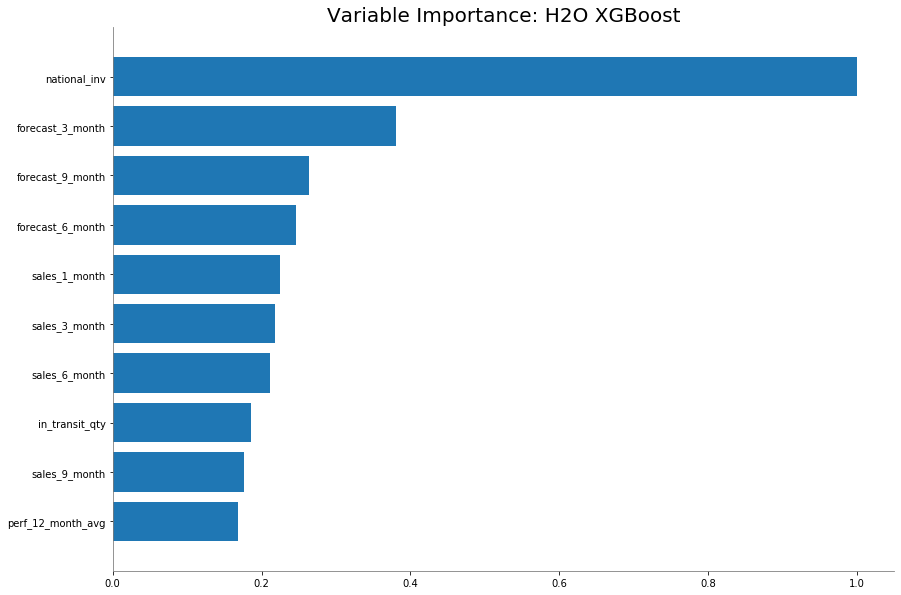

In [20]:
h2o.get_model([mid for mid in model_ids if "XGBoost_1" in mid][0]).varimp_plot()

and so on.

## AutoML In Dotscience
Returning to Dotscience, the details of each model run can be seen in the runs tab, and the model performances in the explore tab.  
These are also still quite basic and will be improved in the future, but the correct and versioned information is there.

## Save Leader Model

There are two ways to save the leader model -- binary format and MOJO format.  If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [21]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

'/root/product_backorders_model_bin/StackedEnsemble_AllModels_AutoML_20191120_225533'

In [22]:
aml.leader.download_mojo(path = "./")

'/root/StackedEnsemble_AllModels_AutoML_20191120_225533.zip'

## Conclusion
 - We have demonstrated that the modeling power of H2O's AutoML can be harnessed within Dotscience, combined with the power of our tracking and versioning capabilities.
 - Usage of H2O within Dotscience is not limited to AutoML: its other functionality, for example individual algorithms, and the data prep capability exemplified by the df.describe(), are also available.